In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [21]:
print("TensorFlow GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
class CNN:
    def __init__(self, data_shape, classes, learning_rate = 0.001, n_epochs = 4, b_size = 30):
        self.lr = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = b_size
        self.classes = classes
        self.K1 = np.sqrt(2/9)*np.random.randn(3, 3, 1, 16)
        self.B1 = np.zeros([16])
        self.K2 = np.sqrt(2/144)*np.random.randn(3, 3, 16, 32)
        self.B2 = np.zeros([32])
        self.w3 = np.sqrt(2/32)*np.random.randn(classes, self.K2.shape[3])
        self.b3 = np.zeros([classes])

    def _max_pool_backprop(self, dP, indices):
        O = np.zeros([dP.shape[0], dP.shape[1]*2, dP.shape[2]*2, dP.shape[3]])
        indices_flat = tf.reshape(indices, [-1, 1])
        dP_flat = tf.reshape(dP, [-1])
        O_flat = tf.tensor_scatter_nd_add(tf.reshape(O, [-1]), indices_flat, dP_flat)
        return tf.reshape(O_flat, O.shape)

    def _GAP_backprop(self, F, shape):
        F_reshaped = tf.reshape(F, [F.shape[0], 1, 1, F.shape[1]])
        return tf.broadcast_to(F_reshaped, shape)

    def _ReLU(self, Z):
        return np.maximum(0, Z)

    def _dReLU(self, Z):
        return Z > 0

    def _softmax(self, Z):
        return np.exp(Z)/np.sum(np.exp(Z), axis=1, keepdims=True)

    def _make_hot(self, y):
        Y = np.zeros([len(y), self.classes])
        Y[np.arange(len(y)), y] = 1
        return Y

    def _forward_prop(self, X):
        Z1 = tf.nn.conv2d(X, self.K1, strides=[1, 1, 1, 1], padding='SAME').numpy() + self.B1
        A1 = self._ReLU(Z1)
        P1, indices1 = tf.nn.max_pool_with_argmax(A1, ksize=2, strides=2, padding='VALID', include_batch_in_index=True)

        Z2 = tf.nn.conv2d(P1, self.K2, strides=[1, 1, 1, 1], padding='SAME').numpy() + self.B2
        A2 = self._ReLU(Z2)
        P2, indices2 = tf.nn.max_pool_with_argmax(A2, ksize=2, strides=2, padding='VALID', include_batch_in_index=True)

        F = np.average(P2, axis = (1, 2))
        Z3 = np.dot(F, self.w3.T) + self.b3
        A3 = self._softmax(Z3)

        return Z1, P1, indices1, Z2, indices2, F, A3

    def _back_prop(self, Z1, P1, indices1, Z2, indices2, F, A3, X, Y):
        n = len(Y)
        dZ3 = A3 - Y
        dw3 = 1/n * np.dot(dZ3.T, F)
        db3 = 1/n * np.sum(dZ3, axis = 0)
        dF = np.dot(dZ3, self.w3)

        dP2 = self._GAP_backprop(dF, [Z2.shape[0], Z2.shape[1]//2, Z2.shape[2]//2, Z2.shape[3]])

        dA2 = self._max_pool_backprop(dP2, indices2)
        dZ2 = dA2 * self._dReLU(Z2)
        dK2 = tf.compat.v1.nn.conv2d_backprop_filter(P1, self.K2.shape, dZ2, strides=[1, 1, 1, 1], padding='SAME').numpy()
        dB2 = np.sum(dZ2, axis = (0, 1, 2))

        dP1 = tf.compat.v1.nn.conv2d_backprop_input(P1.shape, self.K2, dZ2, strides=[1, 1, 1, 1], padding='SAME').numpy()
        dA1 = self._max_pool_backprop(dP1, indices1)
        dZ1 = dA1 * self._dReLU(Z1)
        dK1 = tf.compat.v1.nn.conv2d_backprop_filter(X, self.K1.shape, dZ1, strides=[1, 1, 1, 1], padding='SAME').numpy()
        dB1 = np.sum(dZ1, axis = (0, 1, 2))

        return dK1, dB1, dK2, dB2, dw3, db3

    def _update_params(self, dK1, dB1, dK2, dB2, dw3, db3):
        self.K1 -= self.lr*dK1
        self.B1 -= self.lr*dB1
        self.K2 -= self.lr*dK2
        self.B2 -= self.lr*dB2
        self.w3 -= self.lr*dw3
        self.b3 -= self.lr*db3

    def fit(self, X, y):
        Y = self._make_hot(y)

        n_samples = X.shape[0]
        n_batches = n_samples // self.batch_size

        for epoch in range(self.n_epochs):
            shuffled_indexes = np.random.permutation(n_samples)
            X = X[shuffled_indexes]
            Y = Y[shuffled_indexes]

            for batch in range(n_batches):
                start = batch * self.batch_size
                end = start + self.batch_size
                X_batch = X[start:end]
                Y_batch = Y[start:end]

                Z1, P1, indices1, Z2, indices2, F, A3 = self._forward_prop(X_batch)
                dK1, dB1, dK2, dB2, dw3, db3 = self._back_prop(Z1, P1, indices1, Z2, indices2, F, A3, X_batch, Y_batch)
                self._update_params(dK1, dB1, dK2, dB2, dw3, db3)

    def predict(self, X):
        _, _, _, _, _, _, A3 = self._forward_prop(X)
        return np.argmax(A3, axis=1)

    def calc_accuracy(self, y_hat, y):
        correct_predictions = sum(p == a for p, a in zip(y_hat, y))
        total_predictions = len(y_hat)

        accuracy = correct_predictions / total_predictions
        return accuracy

In [23]:
keras.datasets.mnist.load_data(path="mnist.npz")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train, x_test = x_train/255, x_test/255
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

x_test.shape

(10000, 28, 28, 1)

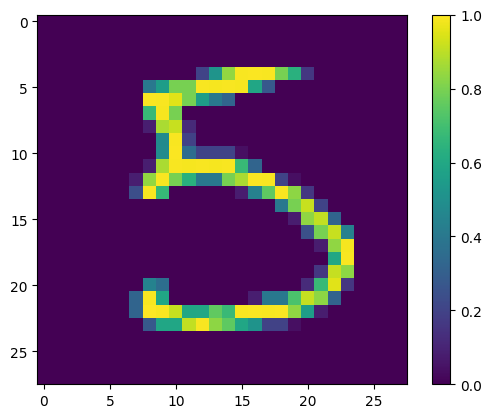

In [24]:
# Image example

plt.figure()
plt.imshow(x_test[15])
plt.colorbar()
plt.grid(False)
plt.show()

In [25]:
LA = CNN(x_train.shape, max(y_train) + 1)
LA.fit(x_train, y_train)
print(f"Predicted labels sample: {LA.predict(x_test[20:50])}")
print(f"   Actual labels sample: {y_test[20:50]}")
print(f"         Model accuracy: {LA.calc_accuracy(LA.predict(x_test), y_test)}")

Predicted labels sample: [7 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4]
   Actual labels sample: [9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4]
         Model accuracy: 0.95
